In [1]:
#from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import os

import librosa as l
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn

# Keras
import keras
import keras_metrics
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.optimizers import RMSprop

In [2]:
#%pip install keras_metrics

In [3]:
final_df = pd.read_csv('../Datasets/merged_df.csv')

# drop first column
final_df.drop('Unnamed: 0', axis='columns', inplace=True)

# train-test split dataset
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

final_df_testing = final_df.copy()
final_df_testing = shuffle(final_df_testing)

X = final_df_testing.drop(columns=['Path', 'Emotions'], axis=1)
y = final_df_testing['Emotions']
print(X.shape, y.shape)

(23364, 173) (23364,)


In [4]:
# Handle imbalance classes with SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

print('Original dataset shape', Counter(y))
print('\n')
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({2: 2192, 4: 2192, 6: 2192, 3: 2192, 0: 2192, 5: 1920, 14: 1534, 8: 1534, 12: 1534, 11: 1534, 10: 1534, 13: 1246, 7: 992, 1: 192, 15: 192, 9: 192})


Resample dataset shape Counter({2: 2192, 4: 2192, 6: 2192, 13: 2192, 14: 2192, 1: 2192, 8: 2192, 12: 2192, 11: 2192, 15: 2192, 7: 2192, 5: 2192, 3: 2192, 9: 2192, 0: 2192, 10: 2192})


In [5]:
X_train

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,...,MEL124,MEL125,MEL126,MEL127,TONZ0,TONZ1,TONZ2,TONZ3,TONZ4,TONZ5
31456,-325.632849,111.724722,23.095899,34.580446,6.045401,-3.557773,-11.071523,-0.389859,-12.144192,-2.198838,...,4.018282e-05,4.103124e-05,4.069006e-05,4.093842e-05,0.029359,-0.032194,-0.041392,-0.069924,0.014577,0.028888
3063,-411.409446,68.541127,25.757919,-6.207421,1.665189,-3.704559,-4.587550,-1.899622,-18.356873,-7.733534,...,1.023052e-03,6.160875e-04,2.937804e-04,2.704587e-05,-0.027106,0.011144,0.003060,-0.072446,0.022097,0.007557
24585,-671.303192,49.270925,0.936135,6.190622,1.830594,-7.199452,-8.787867,-9.191670,-8.334380,-3.459878,...,1.248088e-04,2.045574e-04,1.661237e-04,1.337729e-05,0.018712,0.038758,-0.003136,-0.013195,0.015086,-0.000807
6531,-425.509700,155.334840,-8.840434,39.486397,-10.497147,28.919140,-19.025991,14.482719,-10.085913,-3.670700,...,3.174882e-09,3.107027e-09,3.062988e-09,3.035868e-09,-0.012695,-0.003262,-0.057692,0.010167,0.006460,-0.011064
26280,-366.895996,42.225014,5.148424,-0.984422,-3.457117,-1.201901,-10.801743,-1.752814,-11.854967,-7.791772,...,3.772931e-04,3.509544e-04,2.498391e-04,9.186335e-05,-0.006862,-0.008599,0.053448,-0.000974,0.008263,-0.011474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,-396.684300,51.002758,-4.598436,-1.299707,-0.777938,-1.225899,-17.921484,-0.615977,-12.099292,2.144746,...,3.185960e-04,2.239626e-04,1.362541e-04,1.068181e-05,-0.008891,-0.031592,-0.139641,-0.036337,0.011373,-0.042805
6265,-429.918060,13.987488,-25.794744,-0.567507,-13.151174,-9.664351,-17.374819,-16.185960,-8.834062,-4.984042,...,1.064310e-03,1.176235e-03,6.450943e-04,3.892878e-05,0.005642,0.023697,-0.036808,0.032092,0.002018,-0.026993
11284,-377.312350,144.796020,0.025882,49.881890,-16.468119,6.060339,-3.671607,4.369320,-16.137356,0.811780,...,5.331074e-09,5.209166e-09,5.129532e-09,5.080563e-09,-0.010050,0.003724,-0.027035,-0.040139,0.008974,-0.002221
860,-356.203693,76.116394,17.333635,27.579960,5.789426,5.647095,0.378453,5.690581,-3.562054,-1.285844,...,6.086159e-05,5.932323e-05,5.652774e-05,5.981895e-05,-0.019362,-0.018994,-0.055586,-0.061078,0.014304,0.002238


## Using the same model used for the non-augmented and augmented data, we will now use it for the combined data

In [6]:
model = tf.keras.Sequential()

model.add(layers.Conv1D(128, kernel_size=5, strides=1, # first convulational layer
                        padding="same", activation="relu",
                        input_shape=(X_smote.shape[1], 1))) 
#model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Conv1D(64, kernel_size=5, strides=1,  # second convulational layer
                        padding="same", activation="relu"))
#model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Flatten()) # flatten into a 1D array
model.add(layers.Dense(128, activation='relu')) # fully connected layer
model.add(layers.Dense(64, activation='relu')) # fully connected layer

model.add(layers.Dense(16, activation="softmax")) # output layer

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 173, 128)          768       
                                                                 
 conv1d_1 (Conv1D)           (None, 173, 64)           41024     
                                                                 
 flatten (Flatten)           (None, 11072)             0         
                                                                 
 dense (Dense)               (None, 128)               1417344   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
Total params: 1468432 (5.60 MB)
Trainable params: 14684

## We use the same model that we used for the Non-augmented dataset. 

We will apply regularisation (Early Stopping) to monitor the model's performance on a separate validation dataset during training - If the validation loss did not improve after 10 epochs, the training will stop.

In [7]:
from tensorflow.keras import layers, models, callbacks

# Compile the model with appropriate Loss function
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)

#sparse_categorical_crossentropy --> when targets are integer & suitable for multiclasses
#categorical_crossentropy --> when targets are one-hot encoded vectors (binary) 

# Regularisation - Define early stopping callback 
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

epochs = 100

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test,y_test), callbacks=[early_stopping]) 

Epoch 1/100

877/877 [==============================] - 37s 41ms/step - loss: 1.7500 - accuracy: 0.4414 - val_loss: 1.4148 - val_accuracy: 0.5331
Epoch 2/100
877/877 [==============================] - 37s 43ms/step - loss: 1.2755 - accuracy: 0.5758 - val_loss: 1.2276 - val_accuracy: 0.5733
Epoch 3/100
877/877 [==============================] - 36s 41ms/step - loss: 1.1438 - accuracy: 0.6115 - val_loss: 1.1317 - val_accuracy: 0.6051
Epoch 4/100
877/877 [==============================] - 36s 41ms/step - loss: 1.0623 - accuracy: 0.6332 - val_loss: 1.0926 - val_accuracy: 0.6188
Epoch 5/100
877/877 [==============================] - 36s 41ms/step - loss: 1.0041 - accuracy: 0.6481 - val_loss: 1.0734 - val_accuracy: 0.6302
Epoch 6/100
877/877 [==============================] - 36s 41ms/step - loss: 0.9567 - accuracy: 0.6601 - val_loss: 0.9986 - val_accuracy: 0.6552
Epoch 7/100
877/877 [==============================] - 37s 43ms/step - loss: 0.9202 - accuracy: 0.6743 - val_loss: 0.9787 - val_a

## In this case, the model stopped at 50 epochs.

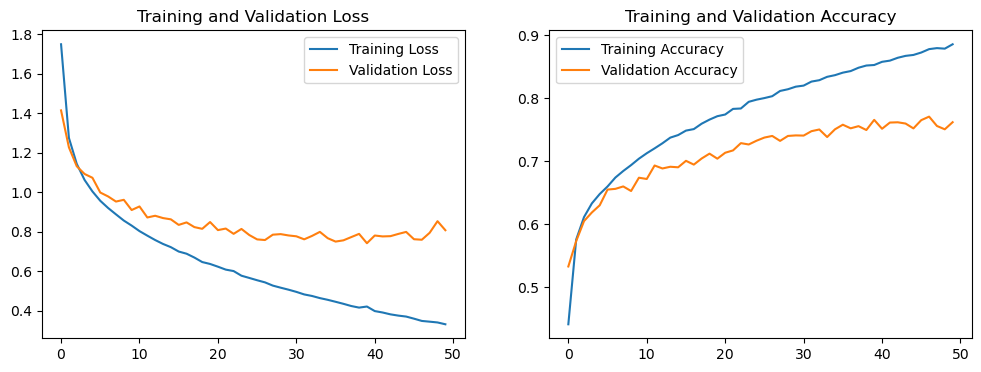

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Make predictions and calculate metrics
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate Precision, Recall, F1-Score
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
f1 = f1_score(y_test, predicted_classes, average='weighted')

print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

print("\n")

# For a detailed classification report including precision, recall, f1-score per class
print(classification_report(y_test, predicted_classes))

220/220 [==============================] - 1s 6ms/step
Precision: 0.7678749025491458, Recall: 0.7620812544547398, F1-Score: 0.7586572672324755


              precision    recall  f1-score   support

           0       0.85      0.80      0.83       430
           1       0.96      1.00      0.98       425
           2       0.64      0.67      0.66       439
           3       0.74      0.76      0.75       427
           4       0.80      0.69      0.74       450
           5       0.79      0.75      0.77       452
           6       0.63      0.76      0.69       455
           7       0.95      0.99      0.97       432
           8       0.76      0.87      0.81       419
           9       0.95      1.00      0.97       431
          10       0.52      0.66      0.58       433
          11       0.58      0.67      0.62       439
          12       0.69      0.62      0.65       461
          13       0.78      0.59      0.67       441
          14       0.76      0.41      0.53 

## Based on this, 50 seems to be the optimal (highest accuracy with the least loss) number of epochs to train the model with.